In [ ]:
! pip install -q kaggle

In [ ]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download balraj98/cvcclinicdb

 99% 130M/131M [00:06<00:00, 25.5MB/s]
100% 131M/131M [00:06<00:00, 20.4MB/s]


In [ ]:
! unzip cvcclinicdb

In [ ]:
import os, cv2
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as album

In [ ]:
!pip install -q -U segmentation-models-pytorch albumentations
import segmentation_models_pytorch as smp

In [ ]:
metadata_df = pd.read_csv('metadata.csv')
metadata_df = metadata_df[['frame_id', 'png_image_path', 'png_mask_path']]
metadata_df['png_image_path'] = metadata_df['png_image_path']
metadata_df['png_mask_path'] = metadata_df['png_mask_path']
metadata_df = metadata_df.sample(frac=1).reset_index(drop=True)

valid_df = metadata_df.sample(frac=0.1, random_state=42)
train_df = metadata_df.drop(valid_df.index)
len(train_df), len(valid_df)

(551, 61)

In [ ]:
class_dict = pd.read_csv('class_dict.csv')
class_names = class_dict['class_names'].tolist()
class_rgb_values = class_dict[['r','g','b']].values.tolist()

print('All dataset classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

All dataset classes and their corresponding RGB values in labels:
Class Names:  ['background', 'polyp']
Class RGB values:  [[0, 0, 0], [255, 255, 255]]


In [ ]:
select_classes = ['background', 'polyp']

select_class_indices = [class_names.index(cls.lower()) for cls in select_classes]
select_class_rgb_values =  np.array(class_rgb_values)[select_class_indices]

print('Selected classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

Selected classes and their corresponding RGB values in labels:
Class Names:  ['background', 'polyp']
Class RGB values:  [[0, 0, 0], [255, 255, 255]]


In [ ]:
def visualize(**images):
    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]);
        plt.yticks([])
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()

In [ ]:
def one_hot_encode(label, label_values):
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)

    return semantic_map

In [ ]:
def reverse_one_hot(image):
    x = np.argmax(image, axis = -1)
    return x

In [ ]:
def colour_code_segmentation(image, label_values):
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]

    return x

In [ ]:
class EndoscopyDataset(torch.utils.data.Dataset):
    def __init__(self, df,class_rgb_values=None,augmentation=None,preprocessing=None):
      self.image_paths = df['png_image_path'].tolist()
      self.mask_paths = df['png_mask_path'].tolist()

      self.class_rgb_values = class_rgb_values
      self.augmentation = augmentation
      self.preprocessing = preprocessing

    def __getitem__(self, i):

        image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2RGB)

        mask = one_hot_encode(mask, self.class_rgb_values).astype('float')

        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

    def __len__(self):
        return len(self.image_paths)

In [ ]:
dataset = EndoscopyDataset(train_df, class_rgb_values=select_class_rgb_values)
random_idx = random.randint(0, len(dataset)-1)
image, mask = dataset[2]

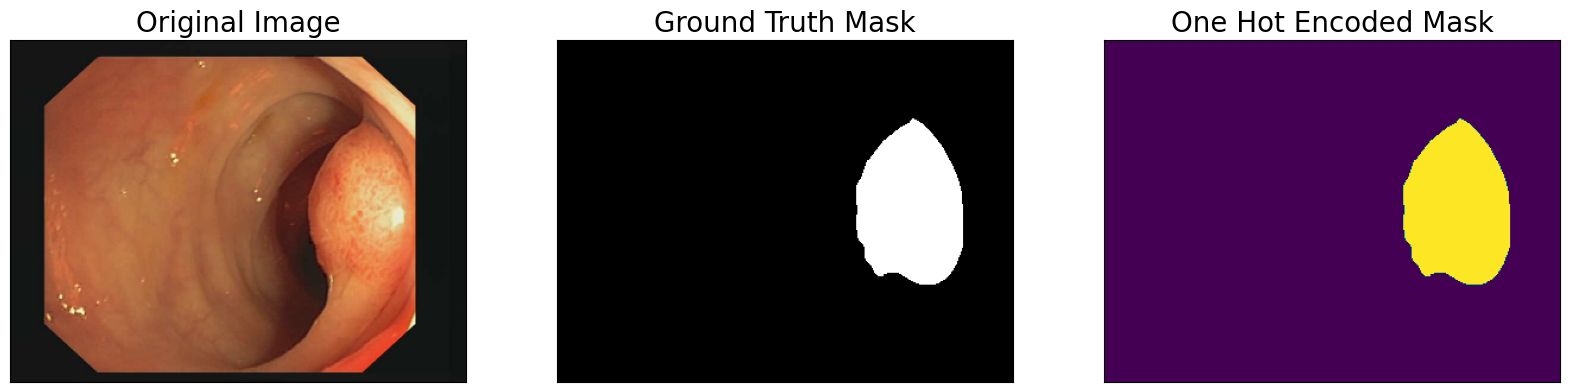

In [ ]:
visualize(original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask))

In [ ]:
def get_training_augmentation():
    train_transform = [album.HorizontalFlip(p=0.5)]
    return album.Compose(train_transform)

In [ ]:
def get_validation_augmentation():
    test_transform = [album.PadIfNeeded(min_height=288, min_width=384, always_apply=True, border_mode=0)]
    return album.Compose(test_transform)

In [ ]:
def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

In [ ]:
def get_preprocessing(preprocessing_fn=None):
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))

    return album.Compose(_transform)

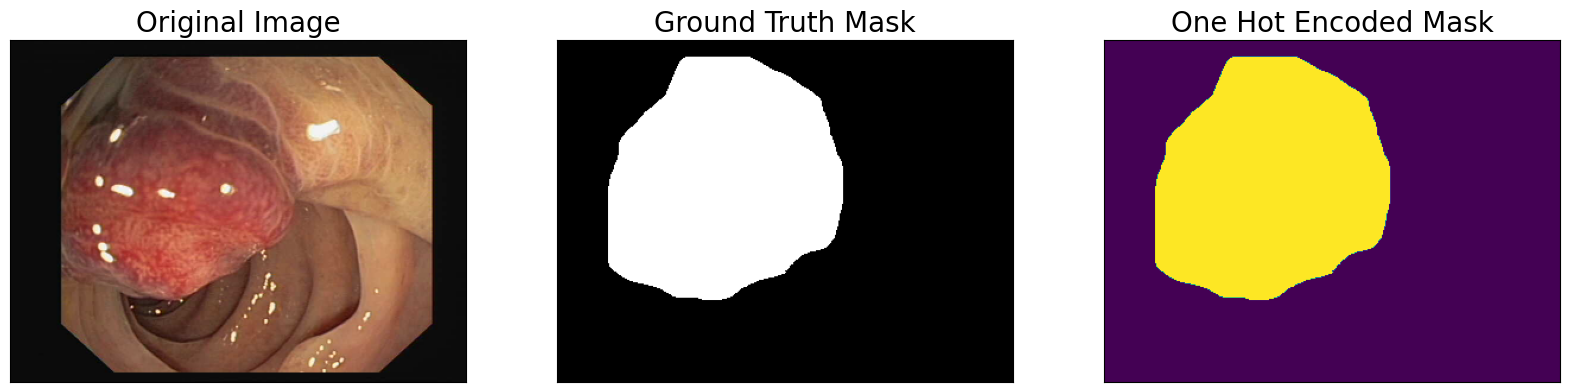

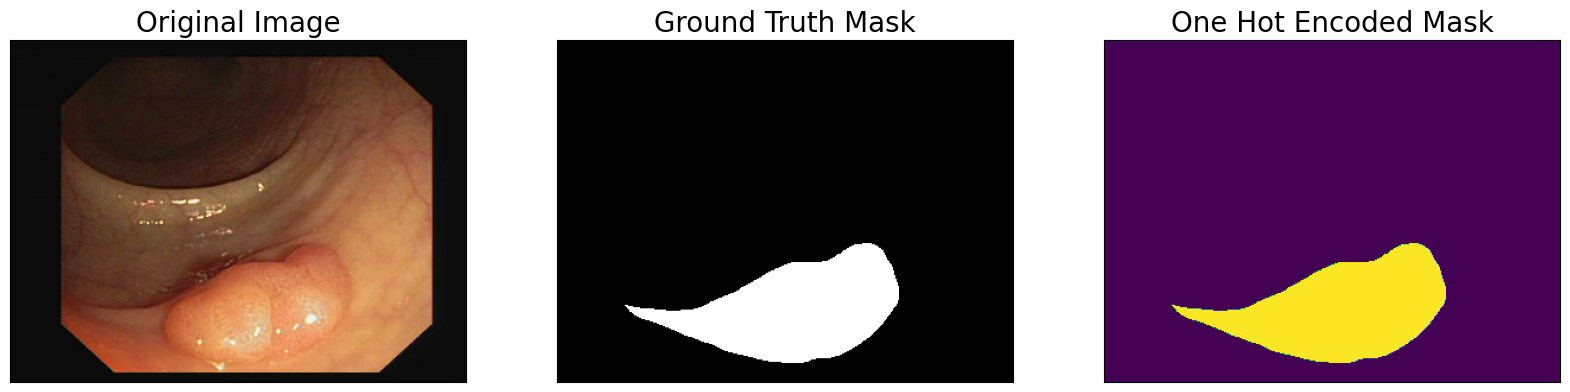

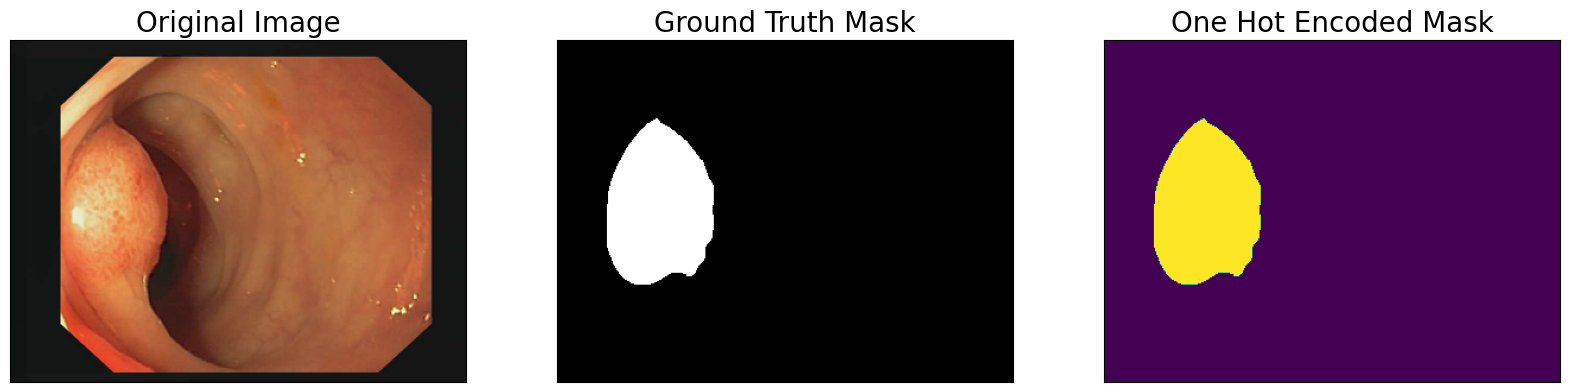

In [ ]:
augmented_dataset = EndoscopyDataset(train_df, augmentation=get_training_augmentation(),
                                     class_rgb_values=select_class_rgb_values)

random_idx = random.randint(0, len(augmented_dataset)-1)

for idx in range(3):
    image, mask = augmented_dataset[idx]
    visualize(original_image = image,
        ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
        one_hot_encoded_mask = reverse_one_hot(mask))

In [ ]:
encoder = 'resnet50'
encoder_wts = 'imagenet'
Classes = select_classes
Activation = 'sigmoid'

model = smp.Unet(encoder_name=encoder, encoder_weights=encoder_wts, classes=len(Classes), activation=Activation,)

preprocessing_fn = smp.encoders.get_preprocessing_fn(encoder, encoder_wts)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 287MB/s]


In [ ]:
train_dataset = EndoscopyDataset(train_df,augmentation=get_training_augmentation(),
                                 preprocessing=get_preprocessing(preprocessing_fn),
                                 class_rgb_values=select_class_rgb_values)

valid_dataset = EndoscopyDataset(valid_df,augmentation=get_validation_augmentation(),
                                 preprocessing=get_preprocessing(preprocessing_fn),
                                 class_rgb_values=select_class_rgb_values)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=4)

In [ ]:
from segmentation_models_pytorch import utils

In [ ]:
TRAINING = True
EPOCHS = 10
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

loss = smp.utils.losses.DiceLoss()
metrics = [smp.utils.metrics.IoU(threshold=0.5)]

optimizer = torch.optim.Adam([dict(params=model.parameters(), lr=0.0001)])

lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=1, T_mult=2, eta_min=5e-5)

In [ ]:
train_epoch = smp.utils.train.TrainEpoch(model, loss=loss,metrics=metrics,optimizer=optimizer,device=DEVICE,verbose=True)

valid_epoch = smp.utils.train.ValidEpoch(model, loss=loss, metrics=metrics, device=DEVICE,verbose=True)

In [ ]:
%%time
if TRAINING:

    best_iou_score = 0.0
    train_logs_list, valid_logs_list = [], []

    for i in range(0, EPOCHS):
        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(valid_loader)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)

        if best_iou_score < valid_logs['iou_score']:
            best_iou_score = valid_logs['iou_score']
            torch.save(model, 'Unet_model.pth')
            print('Model saved!')


Epoch: 0
valid: 100%|██████████| 4/4 [00:02<00:00,  1.59it/s, dice_loss - 0.3008, iou_score - 0.6822]
Model saved!

Epoch: 1
valid: 100%|██████████| 4/4 [00:01<00:00,  2.27it/s, dice_loss - 0.2511, iou_score - 0.7779]
Model saved!

Epoch: 2
valid: 100%|██████████| 4/4 [00:01<00:00,  2.31it/s, dice_loss - 0.2177, iou_score - 0.8355]
Model saved!

Epoch: 3
valid: 100%|██████████| 4/4 [00:01<00:00,  2.35it/s, dice_loss - 0.1853, iou_score - 0.8927]
Model saved!

Epoch: 4
valid: 100%|██████████| 4/4 [00:02<00:00,  1.75it/s, dice_loss - 0.1548, iou_score - 0.9589]
Model saved!

Epoch: 5
valid: 100%|██████████| 4/4 [00:04<00:00,  1.03s/it, dice_loss - 0.1312, iou_score - 0.9649]
Model saved!

Epoch: 6
valid: 100%|██████████| 4/4 [00:02<00:00,  1.60it/s, dice_loss - 0.1113, iou_score - 0.9718]
Model saved!

Epoch: 7
valid: 100%|██████████| 4/4 [00:02<00:00,  1.76it/s, dice_loss - 0.09741, iou_score - 0.9711]

Epoch: 8
valid: 100%|██████████| 4/4 [00:01<00:00,  2.22it/s, dice_loss - 0.08587, 

In [ ]:
if os.path.exists('Unet_model.pth'):
    Unet_model = torch.load('Unet_model.pth', map_location=DEVICE)
    print('Loaded UNet model from saved')

Loaded UNet model from saved


In [ ]:
test_dataset = EndoscopyDataset(valid_df, augmentation=get_validation_augmentation(),
                                preprocessing=get_preprocessing(preprocessing_fn),
                                class_rgb_values=select_class_rgb_values)

test_dataloader = DataLoader(test_dataset)

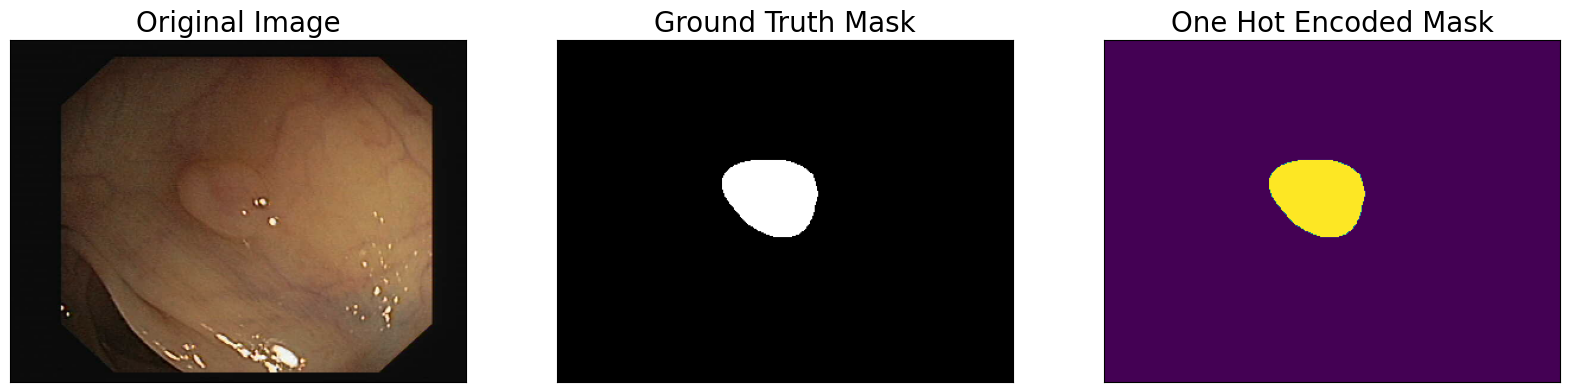

In [ ]:
test_dataset_vis = EndoscopyDataset(valid_df,class_rgb_values=select_class_rgb_values)

random_idx = random.randint(0, len(test_dataset_vis)-1)
image, mask = test_dataset_vis[random_idx]

visualize(original_image = image,ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
          one_hot_encoded_mask = reverse_one_hot(mask))

In [ ]:
def crop_image(image, true_dimensions):
    return album.CenterCrop(p=1, height=true_dimensions[0], width=true_dimensions[1])(image=image)

In [ ]:
sample_preds_folder = 'sample_predictions/'
if not os.path.exists(sample_preds_folder):
    os.makedirs(sample_preds_folder)

In [ ]:
if os.path.exists('Unet_model.pth'):
    Unet_model = torch.load('Unet_model.pth', map_location=DEVICE)

In [ ]:
for idx in range(len(test_dataset)):

    image, gt_mask = test_dataset[idx]
    image_vis = test_dataset_vis[idx][0].astype('uint8')
    true_dimensions = image_vis.shape
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)

    pred_mask = Unet_model(x_tensor)
    pred_mask = pred_mask.detach().squeeze().cpu().numpy()

    pred_mask = np.transpose(pred_mask,(1,2,0))

    pred_polyp_heatmap = crop_image(pred_mask[:,:,select_classes.index('polyp')], true_dimensions)['image']
    pred_mask = crop_image(colour_code_segmentation(reverse_one_hot(pred_mask),
                                                    select_class_rgb_values), true_dimensions)['image']

    gt_mask = np.transpose(gt_mask,(1,2,0))
    gt_mask = crop_image(colour_code_segmentation(reverse_one_hot(gt_mask),
                                                  select_class_rgb_values), true_dimensions)['image']
    cv2.imwrite(os.path.join(sample_preds_folder, f"sample_pred_{idx}.png"),
                np.hstack([image_vis, gt_mask, pred_mask])[:,:,::-1])

    visualize(original_image = image_vis,ground_truth_mask = gt_mask,predicted_mask = pred_mask,
              pred_polyp_heatmap = pred_polyp_heatmap)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
test_epoch = smp.utils.train.ValidEpoch(model,loss=loss, metrics=metrics, device=DEVICE,verbose=True)

valid_logs = test_epoch.run(test_dataloader)
print("Evaluation on Test Data: ")
print(f"Mean IoU Score: {valid_logs['iou_score']:.4f}")
print(f"Mean Dice Loss: {valid_logs['dice_loss']:.4f}")

valid: 100%|██████████| 61/61 [00:02<00:00, 29.13it/s, dice_loss - 0.07194, iou_score - 0.9783]
Evaluation on Test Data: 
Mean IoU Score: 0.9783
Mean Dice Loss: 0.0719


In [ ]:
train_logs_df = pd.DataFrame(train_logs_list)
valid_logs_df = pd.DataFrame(valid_logs_list)
train_logs_df.T

,0,1,2,3,4,5,6,7,8,9
dice_loss,0.354613,0.272956,0.232004,0.200453,0.170527,0.145960,0.123794,0.105768,0.090024,0.076905
iou_score,0.596817,0.729861,0.810917,0.864652,0.931894,0.962832,0.968263,0.969910,0.975154,0.978714


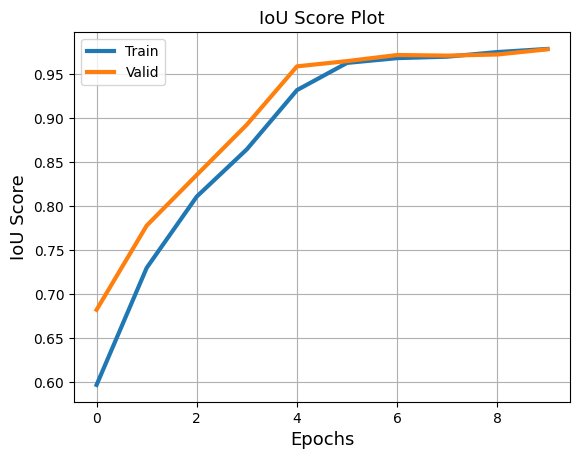

In [ ]:
plt.plot(train_logs_df.index.tolist(), train_logs_df.iou_score.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.iou_score.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=13)
plt.ylabel('IoU Score', fontsize=13)
plt.title('IoU Score Plot', fontsize=13)
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.savefig('iou_score_plot.png')
plt.show()

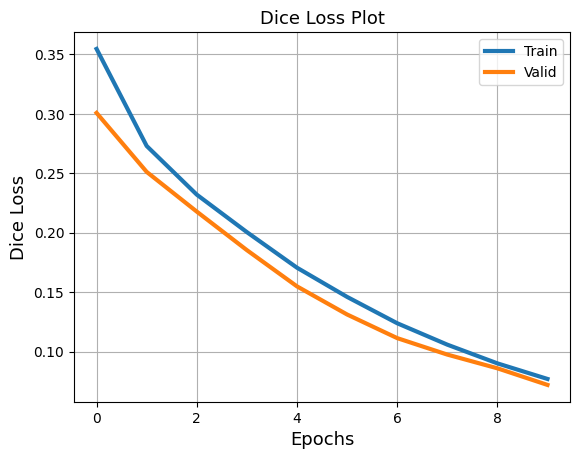

In [ ]:
plt.plot(train_logs_df.index.tolist(), train_logs_df.dice_loss.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.dice_loss.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=13)
plt.ylabel('Dice Loss', fontsize=13)
plt.title('Dice Loss Plot', fontsize=13)
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.savefig('dice_loss_plot.png')
plt.show()
